# WindEye

Use computer vision to identify and analyze wind turbines in satellite imagery.
Part of the GBDX 2018 entry by the World Resources Institute (WRI) and Duke University.
1. Import manually assembled lat/long coordinates for sites with and without wind turbines around the globe.
2. Order imagery clips from WorldView 2 for these locations, grayscale, and resize to standard shape (64x64 pixels).
3. Extract HOG features from images.
4. Train a binary classifier on these HOG features.
5. Deploy the classifier in a new geography to find wind turbines.
6. Deploy the classifier in historical imagery at turbine locations to identify construction date.
7. Train a convolutional neural network (CNN) on images.
8. Repeat steps above with CNN.


In [1]:
# import what we need

import numpy as np
import matplotlib.pyplot as plt
import pickle
import requests
import csv
from itertools import chain
from skimage import color, feature, transform
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda
from keras.layers import Conv2D, Dropout, Activation, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.utils import shuffle
from shapely.geometry import box
from gbdxtools import CatalogImage, Interface
gbdx = Interface()
%matplotlib inline

WIND_TURBINE_COORDINATES = 'wind_turbine_coordinates_all.csv'
NOT_WIND_TURBINE_COORDINATES = 'not_wind_turbine_coordinates_all.csv'
WIND_TURBINE_PICKLE = 'wind_turbine_images.p'
NOT_WIND_TURBINE_PICKLE = 'not_wind_turbine_images.p'
WEIGHTS_FILE = 'model/WindEye_model.h5'
IM_SIZE = 64   # pixels per side for analyzed images
BATCH_SIZE = 64   # size of batches for CNN
VALID_FRACTION = 0.2 # fraction of images used for test/validation

/anaconda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# load images from pickle files

turbine_images_all = pickle.load(open(WIND_TURBINE_PICKLE,'rb'))
not_turbine_images_all = pickle.load(open(NOT_WIND_TURBINE_PICKLE,'rb'))
print(u"Loaded {0} turbine images from pickle file.".format(len(turbine_images_all)))
print(u"Loaded {0} not turbine images from pickle file.".format(len(not_turbine_images_all)))

# need to remove images with NaNs
NaN_indices_turbines = []
for i,hf in enumerate(turbine_images_all):
    if np.any(np.isnan(hf)) or np.any(np.isinf(hf)):
        NaN_indices_turbines.append(i)

NaN_indices_not_turbines = []
for i,hf in enumerate(not_turbine_images_all):
    if np.any(np.isnan(hf)) or np.any(np.isinf(hf)):
        NaN_indices_not_turbines.append(i)
        
# need to add one more dimension (channel) - size 1 for grayscale
turbine_images = [np.expand_dims(turbine_images_all[p],2) for p in range(len(turbine_images_all)) if p not in NaN_indices_turbines]
not_turbine_images = [np.expand_dims(not_turbine_images_all[p],2) for p in range(len(not_turbine_images_all)) if p not in NaN_indices_not_turbines]
        
print(u"Retained {0} turbine images from pickle file.".format(len(turbine_images)))
print(u"Retained {0} not turbine images from pickle file.".format(len(not_turbine_images)))
    
# check image parameters
print(u"Pixel value max: {0}; min: {1}.".format(np.max(turbine_images[0]),np.min(turbine_images[0])))

Loaded 980 turbine images from pickle file.
Loaded 1028 not turbine images from pickle file.
Retained 936 turbine images from pickle file.
Retained 997 not turbine images from pickle file.
Pixel value max: 1.0; min: 0.0.


In [3]:
# now try a CNN

# define generators 

def generator_train(image_list, image_labels, batch_size=BATCH_SIZE):    
    n_samples = len(image_list)
    while True:
        images = []
        labels = []
        while len(images) < BATCH_SIZE:
            sample_index = np.random.randint(n_samples)
            labels.append(image_labels[sample_index])
            im = image_list[sample_index]
            # flip
            flipit = np.random.randint(4)
            if flipit == 0:
                im = np.flip(im,0)  # flip vertically
            elif flipit == 1:
                im = np.flip(im,1)  # flip horizontally
            # rotate
            rotation_choice = np.random.choice([0,90,180,270])
            if rotation_choice != 0:  # save time
                im = transform.rotate(im,rotation_choice)
            images.append(im)   
        yield shuffle(np.array(images),np.array(labels))

def generator_valid(image_list, image_labels, batch_size=BATCH_SIZE):    
    n_samples = len(image_list)
    while True:
        images = []
        labels = []
        while len(images) < BATCH_SIZE:
            sample_index = np.random.randint(n_samples)
            labels.append(image_labels[sample_index])
            im = image_list[sample_index]
            images.append(im)           
        yield shuffle(np.array(images),np.array(labels))


In [4]:
# make generators

all_images = turbine_images + not_turbine_images
all_labels = [1] * len(turbine_images) + [0] * len(not_turbine_images)
perm = np.random.permutation(len(all_images))
all_images_shuffled = [all_images[p] for p in perm]
all_labels_shuffled = [all_labels[p] for p in perm]

X_train_CNN, X_valid_CNN, y_train_CNN, y_valid_CNN = train_test_split(all_images_shuffled,all_labels_shuffled,test_size=VALID_FRACTION)

train_generator = generator_train(X_train_CNN,y_train_CNN)
valid_generator = generator_valid(X_valid_CNN,y_valid_CNN)


In [5]:
# test generators 

gen_test_train = []
gen_test_valid = []
for i in range(3):
    gen_test_train.append(next(train_generator))
    gen_test_valid.append(next(valid_generator))
print(gen_test_train[0][0].shape)
print(gen_test_valid[0][0].shape)

(64, 64, 64, 1)
(64, 64, 64, 1)


In [11]:
# define model
activation_type = 'relu'
IMAGE_SHAPE = turbine_images[0].shape
print(u"Image shape is: {0}".format(IMAGE_SHAPE))

def myNet():
    model = Sequential()
    model.add(Lambda(lambda x: x-0.5,input_shape = IMAGE_SHAPE))
    model.add(Conv2D(32, (5, 5), activation="relu", strides=(2, 2)))
    model.add(MaxPooling2D())
    model.add(Conv2D(16, (5, 5), activation="relu", strides=(2, 2)))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Dense(64))
    model.add(Dense(16))
    model.add(Dense(1,activation='sigmoid'))
    return model
    
model = myNet()
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print("Model contains {0} parameters.".format(model.count_params()))
print(model.summary())

Image shape is: (64, 64, 1)
Model contains 41521 parameters.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_5 (Lambda)            (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 30, 30, 32)        832       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 6, 6, 16)          12816     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 3, 3, 16)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 144)               0         
_________________________________________________________________
dense_9 (Dense)

In [12]:
# fit model

early_stop = EarlyStopping(monitor='val_acc',min_delta=0.0002,patience=32)
check_point = ModelCheckpoint(WEIGHTS_FILE,monitor='val_acc',save_best_only=True,mode='max')
history_object = model.fit_generator(train_generator,
                                    steps_per_epoch=int(len(X_train_CNN)/BATCH_SIZE),
                                    validation_data=valid_generator,
                                    validation_steps=int(len(X_valid_CNN)/BATCH_SIZE),
                                    callbacks = [early_stop,check_point],
                                    epochs=128)

# reload model with best weights from training
model = myNet()
model.load_weights(WEIGHTS_FILE)
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print("Finished training; model reloaded with optimum weights.")
model.save(WEIGHTS_FILE)

Epoch 1/128
24/24 [==============================] - 1s 51ms/step - loss: 0.6248 - acc: 0.6465 - val_loss: 0.5067 - val_acc: 0.8177
Epoch 2/128
24/24 [==============================] - 1s 32ms/step - loss: 0.5085 - acc: 0.7637 - val_loss: 0.4477 - val_acc: 0.7865
Epoch 3/128
24/24 [==============================] - 1s 30ms/step - loss: 0.4335 - acc: 0.8190 - val_loss: 0.3815 - val_acc: 0.8203
Epoch 4/128
24/24 [==============================] - 1s 32ms/step - loss: 0.4172 - acc: 0.8314 - val_loss: 0.4155 - val_acc: 0.8203
Epoch 5/128
24/24 [==============================] - 1s 33ms/step - loss: 0.4139 - acc: 0.8320 - val_loss: 0.3632 - val_acc: 0.8568
Epoch 6/128
24/24 [==============================] - 1s 33ms/step - loss: 0.4202 - acc: 0.8171 - val_loss: 0.3928 - val_acc: 0.8438
Epoch 7/128
24/24 [==============================] - 1s 33ms/step - loss: 0.4111 - acc: 0.8294 - val_loss: 0.3929 - val_acc: 0.8307
Epoch 8/128
24/24 [==============================] - 1s 31ms/step - loss: 0.

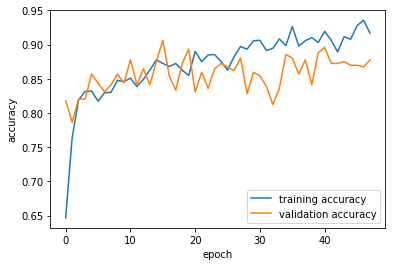

In [13]:
# plot training loss history
    
plt.plot(history_object.history['acc'])
plt.plot(history_object.history['val_acc'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training accuracy','validation accuracy'],loc='lower right')
plt.show()